In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import hashlib

In [2]:
# Importing Classifier Modules
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import preprocessing
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve

In [3]:
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    # Plot n_samples vs fit_times
    # Plot learning curve
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


In [4]:
pokemon = pd.read_csv("pokemon.csv") # Dataset pokemon stats
combats = pd.read_csv("combats.csv") # Datas:qXet pokemon battles and who won

pokemon["Type 2"] = pokemon["Type 2"].fillna("NA")
pokemon.head()


,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False
3,4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,1,False
4,5,Charmander,Fire,NA,39,52,43,60,50,65,1,False


In [5]:
pokemon.columns

Index(['#', 'Name', 'Type 1', 'Type 2', 'HP', 'Attack', 'Defense', 'Sp. Atk',
       'Sp. Def', 'Speed', 'Generation', 'Legendary'],
      dtype='object')

# Data preprocessing

## First approach processing

We wanted to make some comparisons according to our beliefs of what is more impactfull in the outcome of a pokemon battle and for that we need a base comparison, we guided this first approach to an approach seen in [here](https://github.com/kartikeya-rana/pokemon_battle/blob/master/Pokemon.ipynb), in this approach the individual opted to create a new data set that consisted of pokemon 1 stats followed by pokemon 2 statistics and finnaly the winner of the battle, 1 in case the first pokemon wins 0 otherwise, for simplicity purposes it is not possible to have a match with no winner.

## Second approach processing

After that we thought about instead of concatenating both pokemons statistics we wanted to make a subtraction of the first pokemon with the second and compare the new results with the first ones, we also eliminated both the generation and the Legendary information, as well as the type information, since that we know that pokemons of different generation have the same overall raw power, and we also know that pokemon that are legendary do not have big boosts in their stats, and they do not win against every non legendary pokemon

## Third approach processing

This last approach had in account our knowledge of the domain, we believe that pokemons with higher speed and higher attack are more prone to win, therefore we extracted those values and included them in a new dataset.

In [6]:
data_one_hot_encoding = []
extra_data_one_hot_encoding = []
i = 0


# for each tuple of combats.csv
for t in combats.itertuples():
    i += 1
    first_pokemon = t[1] # get the first pokemon
    second_pokemon = t[2] # get the second pokemon
    winner = t[3]         # get the winner

    if i <= 5001:
        x = pokemon.loc[pokemon["#"]==first_pokemon].values[:, 2:][0] # get info about first pokemon
        y = pokemon.loc[pokemon["#"]==second_pokemon].values[:, 2:][0] # get info about second pokemon
        #diff = (x-y)[:6] # difference between "base stats hp...."
        z = np.concatenate((x,y)) 
        if winner == first_pokemon:
            z = np.append(z, [0])
        else:
            z = np.append(z, [1])


        data_one_hot_encoding.append(z)
    elif i < 10000:
        x = pokemon.loc[pokemon["#"]==first_pokemon].values[:, 2:][0] # get info about first pokemon
        y = pokemon.loc[pokemon["#"]==second_pokemon].values[:, 2:][0] # get info about second pokemon
        #diff = (x-y)[:6] # difference between "base stats hp...."
        z = np.concatenate((x,y)) 
        if winner == first_pokemon:
            z = np.append(z, [0])
        else:
            z = np.append(z, [1])


        extra_data_one_hot_encoding.append(z)
    else:
        break
        
        
    
data_one_hot_encoding = np.asarray(data_one_hot_encoding)


In [7]:
data_diff_base_stats = []
extra_data_diff_base_stats = []
i = 0


# for each tuple of combats.csv
for t in combats.itertuples():
    i += 1
    first_pokemon = t[1] # get the first pokemon
    second_pokemon = t[2] # get the second pokemon
    winner = t[3]         # get the winner
    
    if i <= 5001:
        x = pokemon.loc[pokemon["#"]==first_pokemon].values[:, 2:][0] # get info about first pokemon
        y = pokemon.loc[pokemon["#"]==second_pokemon].values[:, 2:][0] # get info about second pokemon
        diff = (x[2:9]-y[2:9]) # difference between "base stats hp...."

        z = []
        z = np.append(diff,z,0)


        if winner == first_pokemon:
            z = np.append(z, [0])
        else:
            z = np.append(z, [1])

        data_diff_base_stats.append(z)
    
    elif i < 10000:
        x = pokemon.loc[pokemon["#"]==first_pokemon].values[:, 2:][0] # get info about first pokemon
        y = pokemon.loc[pokemon["#"]==second_pokemon].values[:, 2:][0] # get info about second pokemon
        diff = (x[2:9]-y[2:9]) # difference between "base stats hp...."

        z = []
        z = np.append(diff,z,0)


        if winner == first_pokemon:
            z = np.append(z, [0])
        else:
            z = np.append(z, [1])

        extra_data_diff_base_stats.append(z)
    else:
        break
    
data_diff_base_stats = np.asarray(data_diff_base_stats)
data_diff_base_stats = data_diff_base_stats[:, :-1].astype(int)

extra_data_diff_base_stats = np.asarray(data_diff_base_stats)
extra_data_diff_base_stats = data_diff_base_stats[:, :-1].astype(int)



In [8]:
pokemon_with_types = pokemon.copy()
types_list = [x for x in pokemon["Type 2"].unique()] + [x for x in pokemon["Type 1"].unique()]

types_list = list(set(types_list))

print(types_list.remove("NA"))
# make NA -> 0
types_list = ["NA"] + types_list

types_map = { x : types_list.index(x) for x in types_list}

pokemon_with_types["Type 1"] = pokemon_with_types["Type 1"].map(types_map)
pokemon_with_types["Type 2"] = pokemon_with_types["Type 2"].map(types_map)

pokemon.head()

print(types_map)
print(types_list)

None
{'NA': 0, 'Steel': 1, 'Water': 2, 'Dark': 3, 'Ground': 4, 'Fighting': 5, 'Fairy': 6, 'Flying': 7, 'Poison': 8, 'Rock': 9, 'Bug': 10, 'Dragon': 11, 'Electric': 12, 'Ice': 13, 'Grass': 14, 'Fire': 15, 'Normal': 16, 'Psychic': 17, 'Ghost': 18}
['NA', 'Steel', 'Water', 'Dark', 'Ground', 'Fighting', 'Fairy', 'Flying', 'Poison', 'Rock', 'Bug', 'Dragon', 'Electric', 'Ice', 'Grass', 'Fire', 'Normal', 'Psychic', 'Ghost']


In [9]:
data_with_types = []
extra_data_with_types = []
i = 0


# for each tuple of combats.csv
for t in combats.itertuples():
    i += 1
    first_pokemon = t[1] # get the first pokemon
    second_pokemon = t[2] # get the second pokemon
    winner = t[3]         # get the winner

    if i <= 5001:
        x = pokemon_with_types.loc[pokemon["#"]==first_pokemon]
        x = x.drop(columns=["Name","#"]).values[0]
        y = pokemon_with_types.loc[pokemon["#"]==second_pokemon].drop(columns=["Name","#"]).values[0]


        z = np.concatenate((x,y)) 

        if winner == first_pokemon:
            z = np.append(z, [0])
        else:
            z = np.append(z, [1])

        data_with_types.append(z)
    elif i < 10000:
        x = pokemon_with_types.loc[pokemon["#"]==first_pokemon]
        x = x.drop(columns=["Name","#"]).values[0]
        y = pokemon_with_types.loc[pokemon["#"]==second_pokemon].drop(columns=["Name","#"]).values[0]


        z = np.concatenate((x,y)) 

        if winner == first_pokemon:
            z = np.append(z, [0])
        else:
            z = np.append(z, [1])

        extra_data_with_types.append(z)
    else:
        break
        
    
data_with_types = np.asarray(data_with_types)
data_with_types= pd.DataFrame(data_with_types, columns=[
       'Type 1', 'Type 2', 'HP', 'Attack', 'Defense', 'Sp. Atk',
       'Sp. Def', 'Speed', 'Generation', 'Legendary' ,
       'Type 1', 'Type 2', 'HP', 'Attack', 'Defense', 'Sp. Atk',
       'Sp. Def', 'Speed', 'Generation', 'Legendary','Win'] )

data_with_types = data_with_types.astype({
       'Type 1':'int32', 'Type 2':'int32', 'HP':'int32', 'Attack':'int32', 'Defense':'int32', 'Sp. Atk':'int32',
       'Sp. Def':'int32', 'Speed':'int32', 'Generation':'int32', 'Legendary':'int32' ,
       'Type 1':'int32', 'Type 2':'int32', 'HP':'int32', 'Attack':'int32', 'Defense':'int32', 'Sp. Atk':'int32',
       'Sp. Def':'int32', 'Speed':'int32', 'Generation':'int32', 'Legendary':'int32','Win':'int32' })


X_imp_feat = data_with_types[['Type 1', 'Type 2','Attack', 'Speed']]

y = data_with_types["Win"]

print(y)




0       1
1       1
2       1
3       1
4       0
       ..
4996    0
4997    1
4998    1
4999    0
5000    1
Name: Win, Length: 5001, dtype: int32


In [10]:
data_with_types.head()

,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,...,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,Win
0,9,4,50,64,50,45,50,41,2,0,...,3,70,70,40,60,40,60,3,0,1
1,14,5,91,90,72,90,129,108,5,1,...,5,91,129,90,72,90,108,5,1,1
2,6,7,55,40,85,80,105,40,2,0,...,0,75,75,75,125,95,40,5,0,1
3,15,0,40,40,40,70,40,20,2,0,...,0,77,120,90,60,90,48,5,0,1
4,9,2,70,60,125,115,70,55,1,0,...,9,20,10,230,10,230,5,2,0,0


### Data correlation number of wins


number of wins is correlated with speed and attack being special attack and defense are also important factors as well as being legendary
Contrary to my beliefs generations are quite well balanced,  since there is almos no correlation between the 2
We can also see that the base stats do not have much correlation with generation, therefore pokemons that belong to diferent generations are on an equal foot in terms of base power.

### Data correlation legendary or not
Once again through this correlation heatmap it is possible to say that generation as no important role to classify a pokemon as legendary, one thing that strikes out is Sp. Attack and Attack as well as Sp. Defense  this seem to be somehow correlated to classifing a pokemon as legendary or not

In [11]:
unique_ids=pokemon['#']
wins_by_id = []
for _id in unique_ids:
    wins_by_id.append([_id ,(combats["Winner"] == _id).sum() ])
    
wins_by_id = np.asarray(wins_by_id)

pokemon["Wins"] = wins_by_id[:,1]
pokemon["Legendary"] = pokemon["Legendary"].astype(int)




<AxesSubplot:>

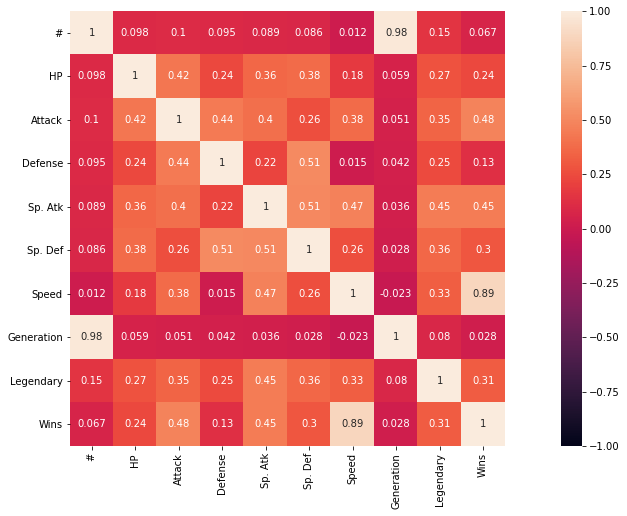

In [12]:

plt.figure(figsize=(20,8))
sns.heatmap(pokemon.corr(),square=True, vmin=-1, vmax=1, annot=True)

### Data correlation number of wins


number of wins is correlated with speed and attack being special attack and defense are also important factors as well as being legendary
Contrary to my beliefs generations are quite well balanced,  since there is almos no correlation between the 2
We can also see that the base stats do not have much correlation with generation, therefore pokemons that belong to diferent generations are on an equal foot in terms of base power.

### Data correlation legendary or not
Once again through this correlation heatmap it is possible to say that generation as no important role to classify a pokemon as legendary, one thing that strikes out is Sp. Attack and Attack as well as Sp. Defense  this seem to be somehow correlated to classifing a pokemon as legendary or not

# Graph that shows the correlation between number of wins and speed

Overall the speed of the pokemon is more impactfull in the outcome of battle than most of the other attributes.

<AxesSubplot:xlabel='Attack'>

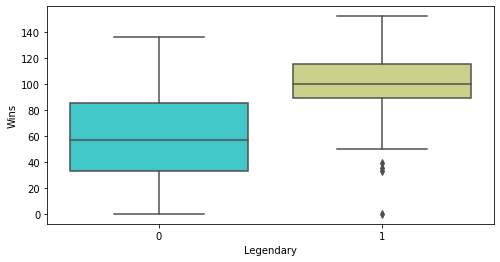

<Figure size 1440x576 with 0 Axes>

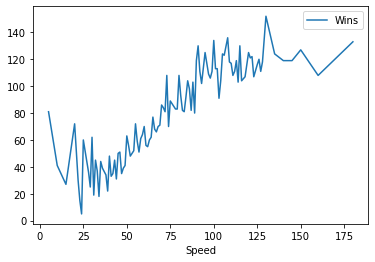

<Figure size 1440x576 with 0 Axes>

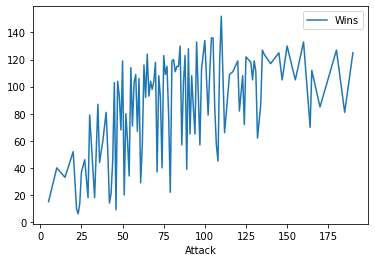

In [13]:
#boxplot of Attack vs. Legendary
plt.figure(figsize=(8, 4))
sns.boxplot(x='Legendary',y='Wins',data=pokemon, palette='rainbow')

#stripplot of speed Wins relation
plt.figure(figsize=(20,8))
speed_wins = pokemon[['Speed','Wins']].groupby(['Speed'], as_index=False).max().set_index('Speed')
speed_wins.sort_values(by='Speed',ascending=True).plot(kind='line')
#stripplot of Attack vs. Legendary, palette='rainbow'
plt.figure(figsize=(20,8))
speed_wins = pokemon[['Attack','Wins']].groupby(['Attack'], as_index=False).max().set_index('Attack')
speed_wins.sort_values(by='Attack',ascending=True).plot(kind='line')


# 1 type pokemon go brr cause strong


<AxesSubplot:xlabel='Type 2'>

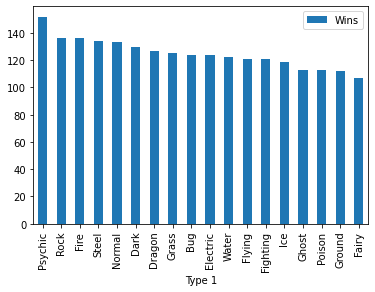

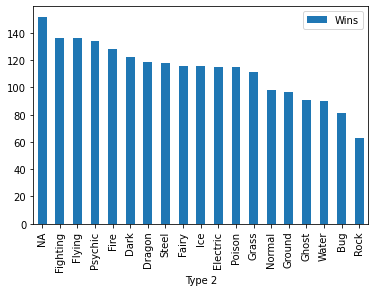

In [14]:
type_1 = pokemon[['Type 1','Wins']].groupby(['Type 1'], as_index=False).max().set_index('Type 1')
type_1.sort_values(by='Wins',ascending=False).plot(kind='bar')

type_2 = pokemon[['Type 2','Wins']].groupby(['Type 2'], as_index=False).max().set_index('Type 2')
type_2.sort_values(by='Wins',ascending=False).plot(kind='bar')

<BarContainer object of 20 artists>

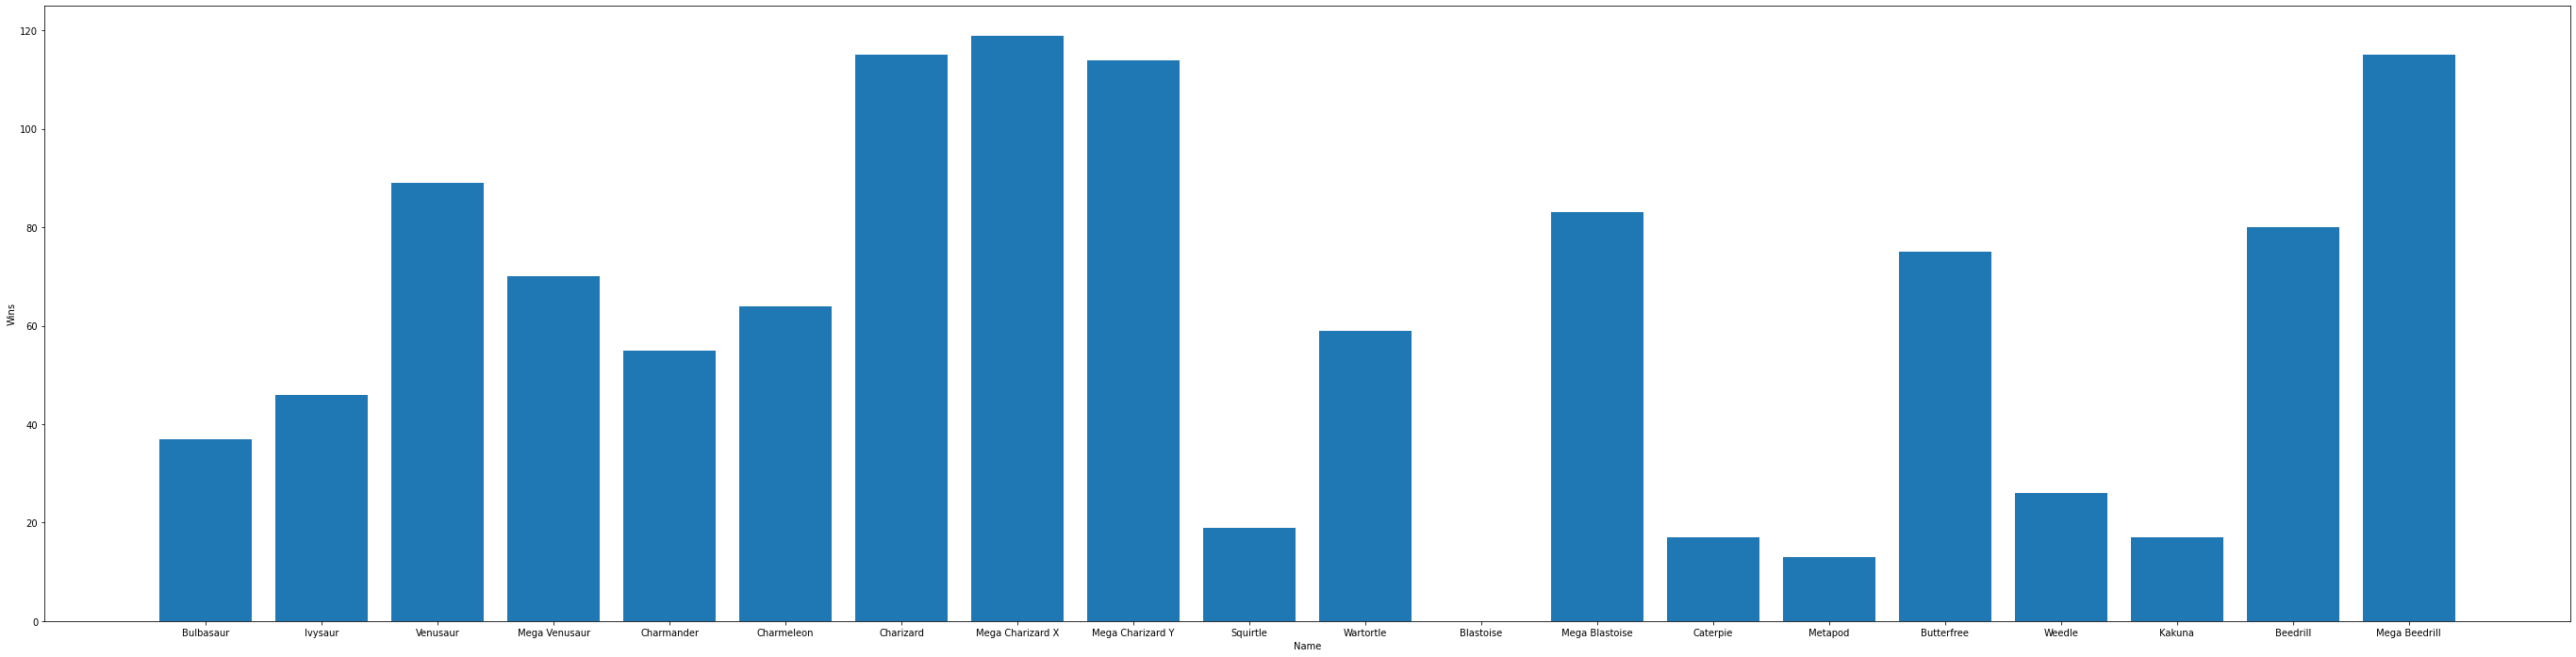

In [15]:
plt.figure(figsize=(48, 12))
plt.xlabel("Name")
plt.ylabel("Wins")
plt.bar(pokemon['Name'][:20], pokemon['Wins'][:20])

Text(0, 0.5, 'Wins')

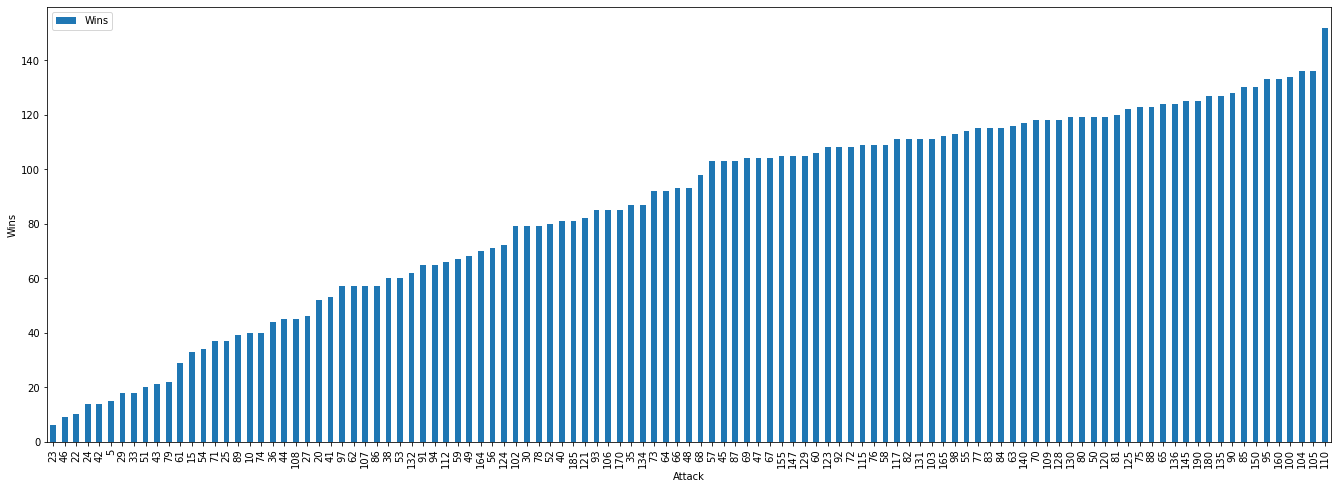

In [16]:

type_1 = pokemon[['Attack','Wins']].groupby(['Attack'], as_index=False).max().set_index('Attack')
type_1.sort_values(by='Wins',ascending=True).plot(kind='bar', figsize=(23,8)).set_ylabel("Wins")
#Number of wins is directly proportional too attack damage

<AxesSubplot:xlabel='Speed'>

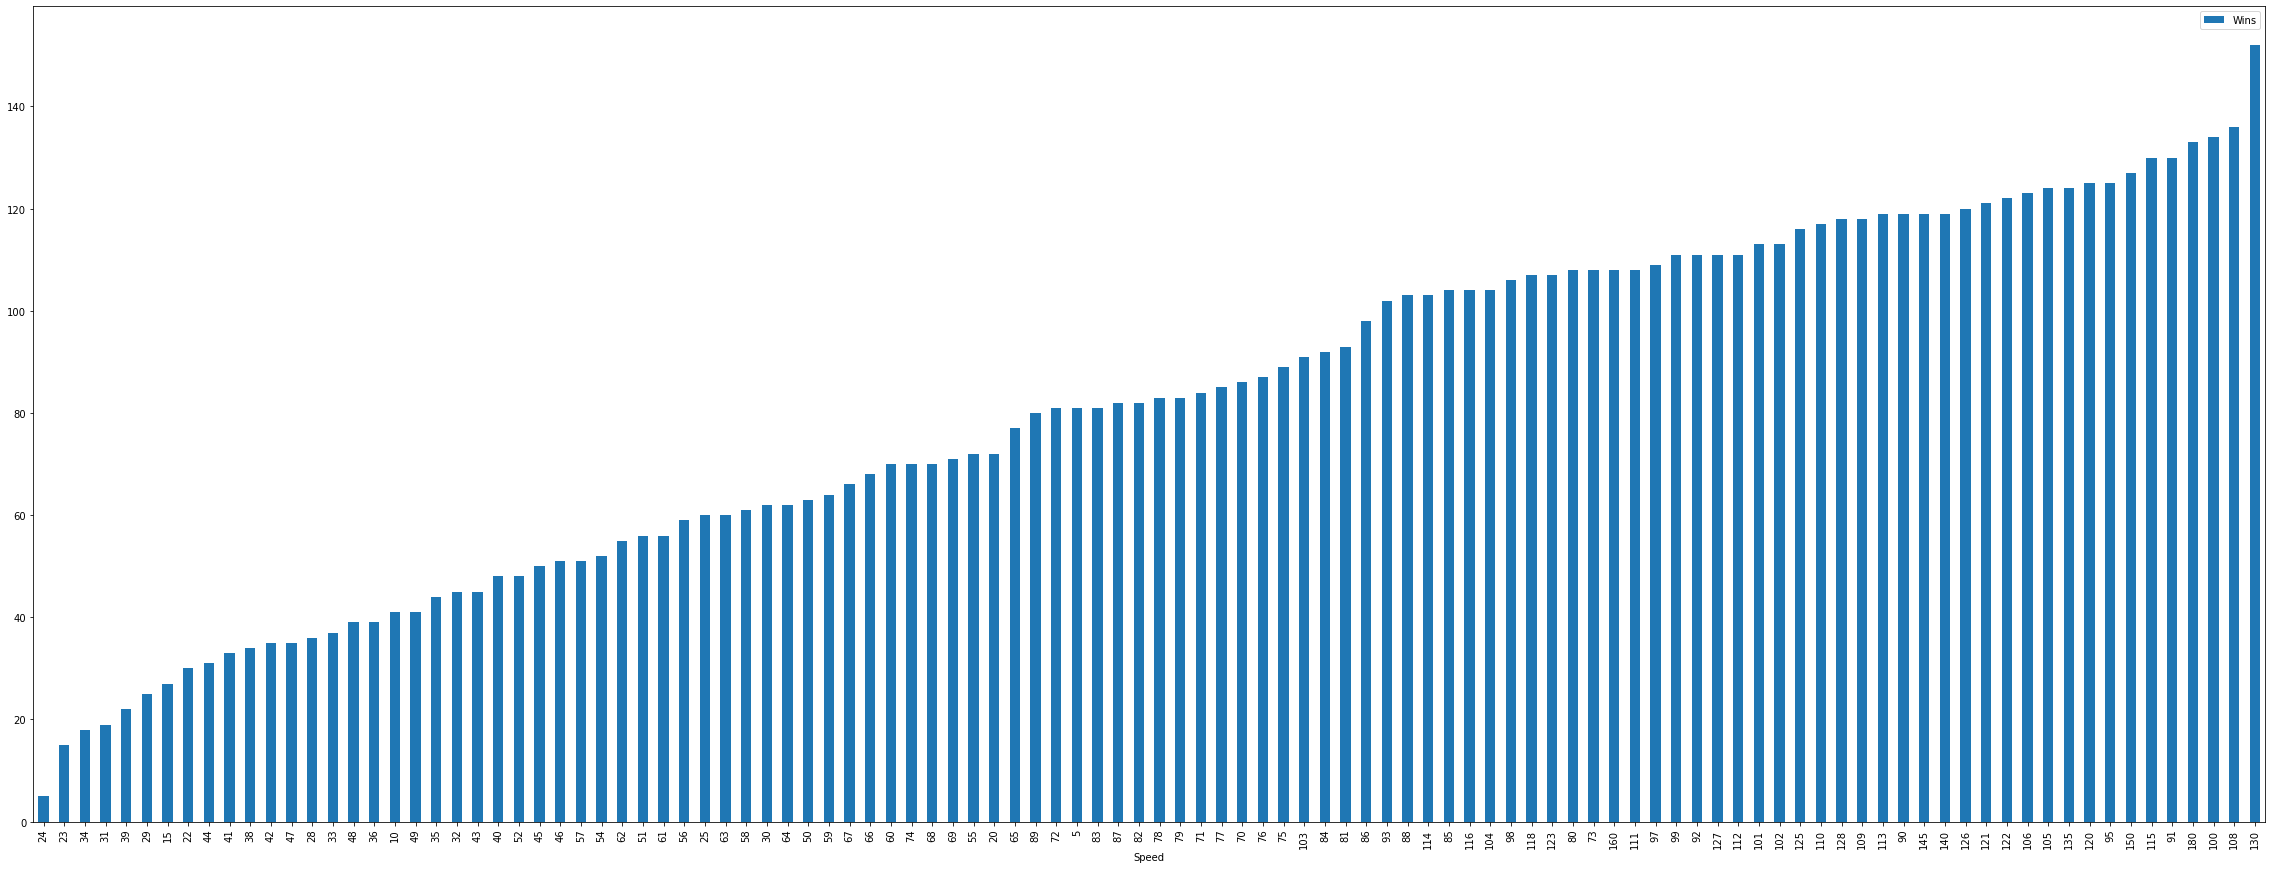

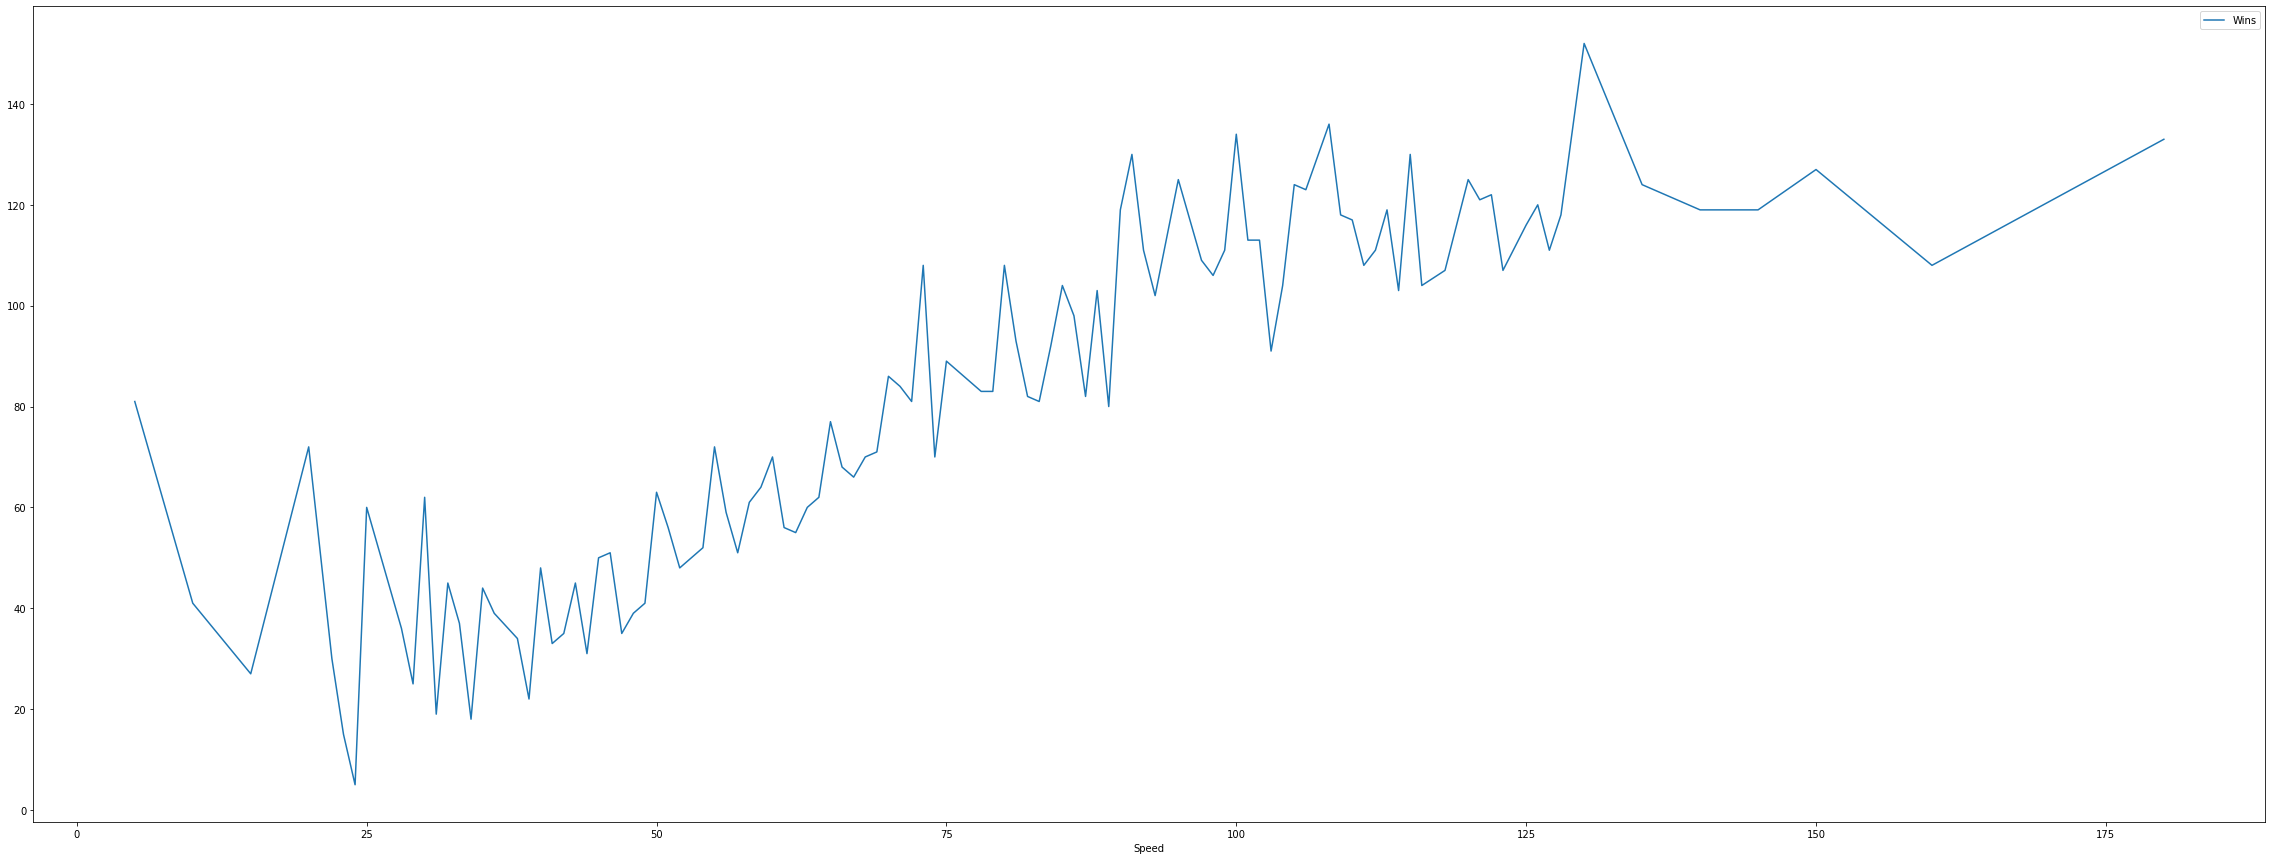

In [17]:
type_1 = pokemon[['Speed','Wins']].groupby(['Speed'], as_index=False).max().set_index('Speed')
type_1.sort_values(by='Wins',ascending=True).plot(kind='bar', figsize=(40,15))
#Number of wins is directly proportional too Speed
type_1 = pokemon[['Speed','Wins']].groupby(['Speed'], as_index=False).max().set_index('Speed')
type_1.sort_values(by='Speed',ascending=True).plot(kind='line', figsize=(40,15))
#Number of wins is directly proportional too Speed

# Classifier Results Not Having in Account Types
As we know types take an important role in pokemon battles, for example a electric pokemon deals 2 times more damage to an water pokemon than to a fire pokemon and to times less damage to a rock pokemon, this interactions might prove challenging to some classification algorithms.

# Second approach

Features usados
HP Diff         int64
Attack Diff     int64
Defens Diff     int64
Sp. Atk diff    int64
Sp. Def dif     int64
Speed diff      int64

In [18]:
data_pd_frame = pd.DataFrame(data_diff_base_stats, columns=["HP Diff", "Attack Diff", "Defens Diff", "Sp. Atk diff", "Sp. Def dif", "Speed diff", "Win" ])
# "HP Diff & Attack Diff & Defens Diff & Sp. Atk diff & Sp. Def dif & Speed diff & Win" 
for column in data_pd_frame.columns:
    data_pd_frame[column] = data_pd_frame[column].astype(int)

In [19]:
data_pd_frame.dtypes

HP Diff         int64
Attack Diff     int64
Defens Diff     int64
Sp. Atk diff    int64
Sp. Def dif     int64
Speed diff      int64
Win             int64
dtype: object

In [20]:
X_diff_stats = data_pd_frame.drop(columns=["Win"]).values

X_diff_train, X_diff_test, y_train, y_test = train_test_split(X_diff_stats , y, test_size=0.25, random_state=42)

88.41 percent


<AxesSubplot:>

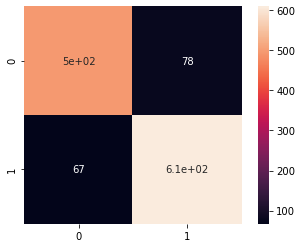

In [21]:
# Logistic Regression 
clf = LogisticRegression(max_iter=10000)
clf.fit(X_diff_train, y_train)
y_pred_log_reg = clf.predict(X_diff_test)
acc_log_reg = round( clf.score(X_diff_test, y_test) * 100, 2)
print(str(acc_log_reg) + ' percent')
sns.heatmap(confusion_matrix(y_test, y_pred_log_reg), square=True, annot=True)

<module 'matplotlib.pyplot' from '/opt/anaconda/lib/python3.8/site-packages/matplotlib/pyplot.py'>

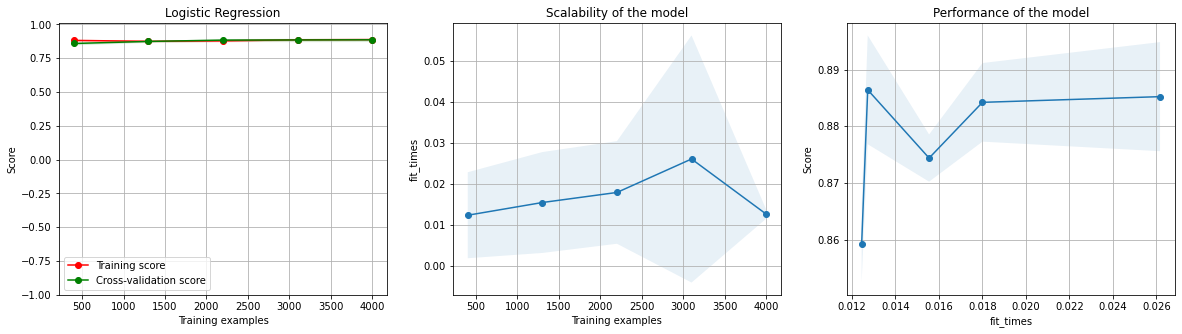

In [22]:
plot_learning_curve(
    clf, "Logistic Regression", X_diff_stats, y,ylim=(-1, 1.01), cv=5, n_jobs=4
)

In [23]:
pd.DataFrame(zip(data_pd_frame.columns, np.transpose(clf.coef_[0])), columns=['features', 'coef']) 

,features,coef
0,HP Diff,-0.000941
1,Attack Diff,-0.009897
2,Defens Diff,-0.003292
3,Sp. Atk diff,0.002448
4,Sp. Def dif,-0.001284
5,Speed diff,-0.061518


Accuracy : 0.9512390087929656
              precision    recall  f1-score   support

           0       0.94      0.95      0.95       574
           1       0.96      0.95      0.95       677

    accuracy                           0.95      1251
   macro avg       0.95      0.95      0.95      1251
weighted avg       0.95      0.95      0.95      1251



<AxesSubplot:>

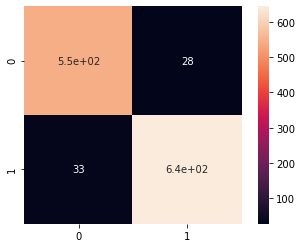

In [24]:
# Random Forest Classifier difference between most imp features
# Every diff
clf = RandomForestClassifier(n_estimators=100)
model = clf.fit(X_diff_train,y_train)
pred = model.predict(X_diff_test)
# print('Accuracy of {}:'.format(name), accuracy_score(pred, y_test))
print('Accuracy :', accuracy_score(pred, y_test))
print(classification_report(y_test, pred))
sns.heatmap(confusion_matrix(y_test, pred), square=True, annot=True)

<module 'matplotlib.pyplot' from '/opt/anaconda/lib/python3.8/site-packages/matplotlib/pyplot.py'>

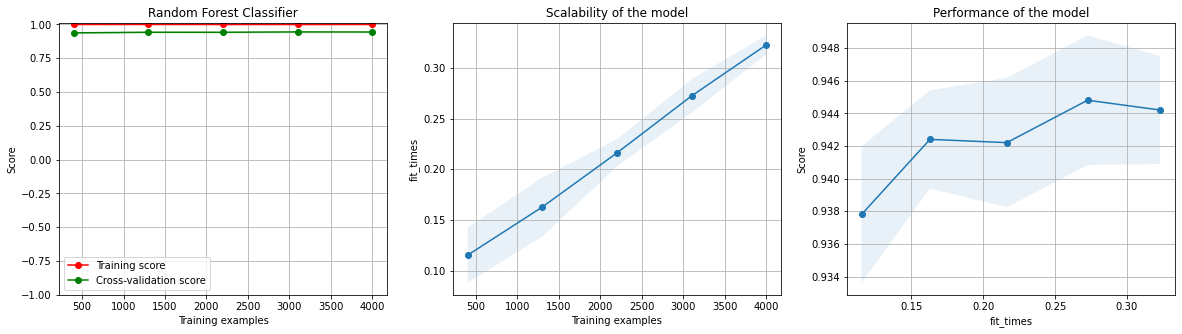

In [25]:
plot_learning_curve(
    clf, "Random Forest Classifier", X_diff_stats, y,ylim=(-1, 1.01), cv=5, n_jobs=4
)

# Leave Only Attack and Speed diff

Accuracy : 0.9408473221422862
              precision    recall  f1-score   support

           0       0.93      0.94      0.94       574
           1       0.95      0.94      0.95       677

    accuracy                           0.94      1251
   macro avg       0.94      0.94      0.94      1251
weighted avg       0.94      0.94      0.94      1251



<AxesSubplot:>

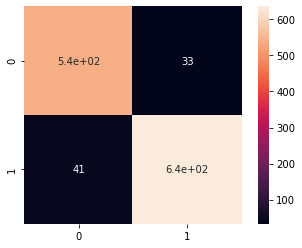

In [26]:
X_Most_Imp_Features = data_pd_frame.drop(columns=["HP Diff", "Sp. Atk diff", "Defens Diff", "Sp. Def dif", "Win"])
X_train, X_test, y_train, y_test = train_test_split(X_Most_Imp_Features, y, test_size=0.25, random_state=42)
randomFlorestclf = RandomForestClassifier(n_estimators=100)
model = randomFlorestclf.fit(X_train,y_train)
pred = model.predict(X_test)
# print('Accuracy of {}:'.format(name), accuracy_score(pred, y_test))
print('Accuracy :', accuracy_score(pred, y_test))
print(classification_report(y_test, pred))
sns.heatmap(confusion_matrix(y_test,pred), square=True, annot=True)

In [27]:
X_Most_Imp_Features.head(2)

,Attack Diff,Speed diff
0,-6,-19
1,-39,0


<module 'matplotlib.pyplot' from '/opt/anaconda/lib/python3.8/site-packages/matplotlib/pyplot.py'>

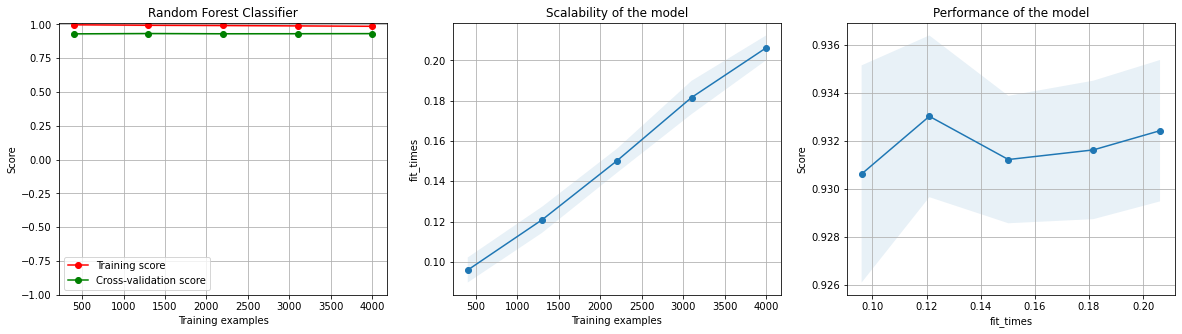

In [28]:
plot_learning_curve(
    randomFlorestclf, "Random Forest Classifier", X_Most_Imp_Features, y,ylim=(-1, 1.01), cv=5, n_jobs=4
)

In [29]:
X_Most_Imp_Features.head(3)

,Attack Diff,Speed diff
0,-6,-19
1,-39,0
2,-35,0


88.73 percent


<AxesSubplot:>

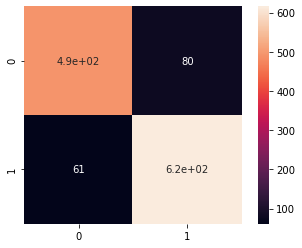

In [30]:
# Logistic Regression difference between most imp features
# Attack Diff Speed Dif
clf = LogisticRegression(C=100,max_iter=10000)
clf.fit(X_train, y_train)
y_pred_log_reg = clf.predict(X_test)
acc_log_reg = round( clf.score(X_test, y_test) * 100, 2)
print(str(acc_log_reg) + ' percent')
sns.heatmap(confusion_matrix(y_test,y_pred_log_reg), square=True, annot=True)

<module 'matplotlib.pyplot' from '/opt/anaconda/lib/python3.8/site-packages/matplotlib/pyplot.py'>

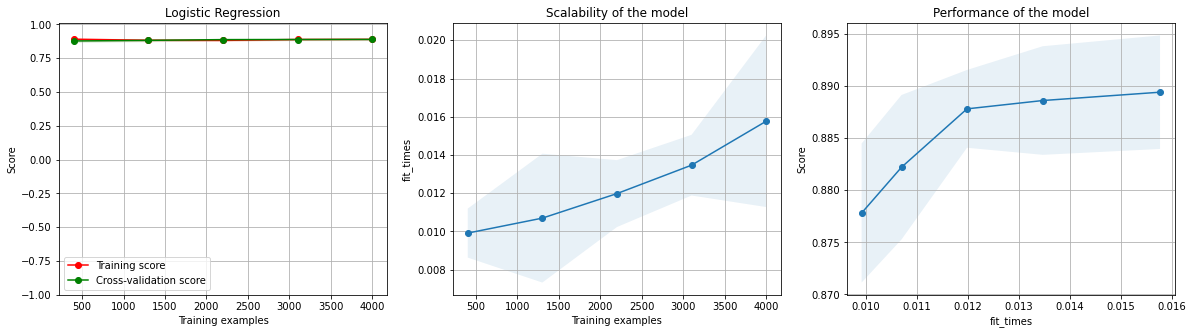

In [31]:
plot_learning_curve(
    clf, "Logistic Regression", X_Most_Imp_Features, y,ylim=(-1, 1.01), cv=5, n_jobs=4
)

# First approach

Pokemon stats in the same row types features encoded as a mapping

In [32]:
data = data_with_types.drop(columns=["Win", "Legendary", "Generation"])

In [33]:
data.head(3)

,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
0,9,4,50,64,50,45,50,41,14,3,70,70,40,60,40,60
1,14,5,91,90,72,90,129,108,9,5,91,129,90,72,90,108
2,6,7,55,40,85,80,105,40,17,0,75,75,75,125,95,40


76.74 percent


<AxesSubplot:>

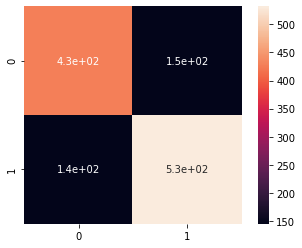

In [34]:
X = data.values[:, :-1].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

clf = LogisticRegression(C=0.1,max_iter=10000)
clf.fit(X_train, y_train)
y_pred_log_reg = clf.predict(X_test)
acc_log_reg = round( clf.score(X_test, y_test) * 100, 2)
print(str(acc_log_reg) + ' percent')
sns.heatmap(confusion_matrix(y_test,y_pred_log_reg), square=True, annot=True)

<module 'matplotlib.pyplot' from '/opt/anaconda/lib/python3.8/site-packages/matplotlib/pyplot.py'>

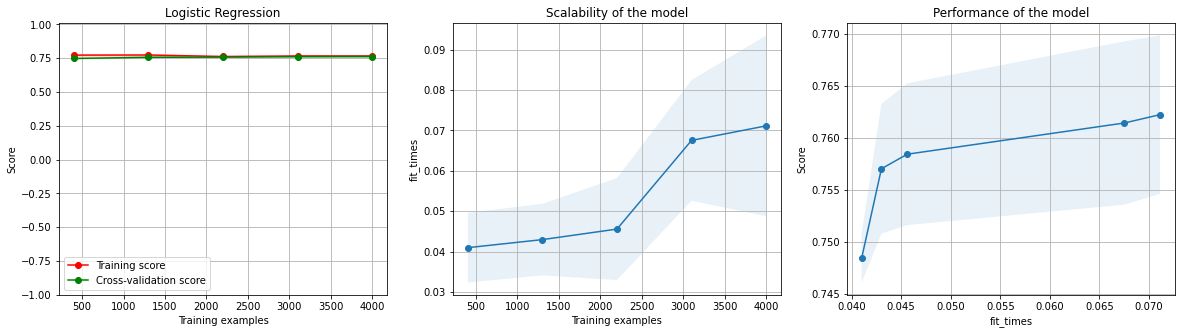

In [35]:
plot_learning_curve(
    clf, "Logistic Regression", X, y,ylim=(-1, 1.01), cv=5, n_jobs=4
)

In [36]:
print(X[0])

[ 9  4 50 64 50 45 50 41 14  3 70 70 40 60 40]


Accuracy : 0.7881694644284573
              precision    recall  f1-score   support

           0       0.77      0.77      0.77       574
           1       0.81      0.80      0.80       677

    accuracy                           0.79      1251
   macro avg       0.79      0.79      0.79      1251
weighted avg       0.79      0.79      0.79      1251



<AxesSubplot:>

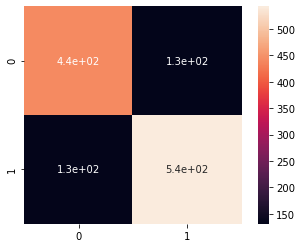

In [37]:
# Random forest Classifier with every stat of both pokemons including types
clf = RandomForestClassifier(n_estimators=100)
model = clf.fit(X_train,y_train)
pred = model.predict(X_test)
# print('Accuracy of {}:'.format(name), accuracy_score(pred, y_test))
print('Accuracy :', accuracy_score(pred, y_test))
print(classification_report(y_test, pred))
sns.heatmap(confusion_matrix(y_test, pred), square=True, annot=True)

<module 'matplotlib.pyplot' from '/opt/anaconda/lib/python3.8/site-packages/matplotlib/pyplot.py'>

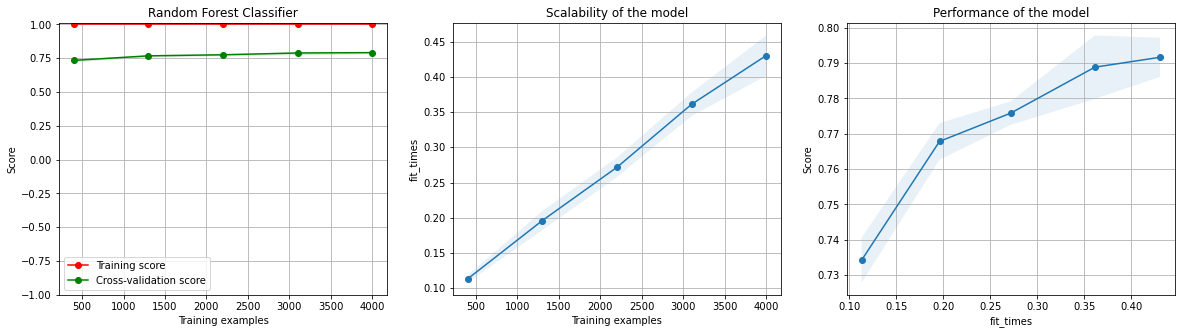

In [38]:
plot_learning_curve(
    clf, "Random Forest Classifier", X, y,ylim=(-1, 1.01), cv=5, n_jobs=4
)

Accuracy : 0.7657873701039168
              precision    recall  f1-score   support

           0       0.74      0.75      0.75       574
           1       0.79      0.78      0.78       677

    accuracy                           0.77      1251
   macro avg       0.76      0.76      0.76      1251
weighted avg       0.77      0.77      0.77      1251



<AxesSubplot:>

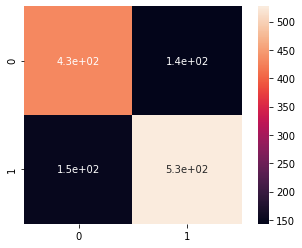

In [39]:
# MLP classifier with every stat as well as types map
clf = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(100, X.shape[1]), random_state=1, max_iter=100000)
model = clf.fit(X_train, y_train)
pred = model.predict(X_test)
print('Accuracy :', accuracy_score(pred, y_test))
print(classification_report(y_test, pred))
sns.heatmap(confusion_matrix(y_test, pred), square=True, annot=True)


<module 'matplotlib.pyplot' from '/opt/anaconda/lib/python3.8/site-packages/matplotlib/pyplot.py'>

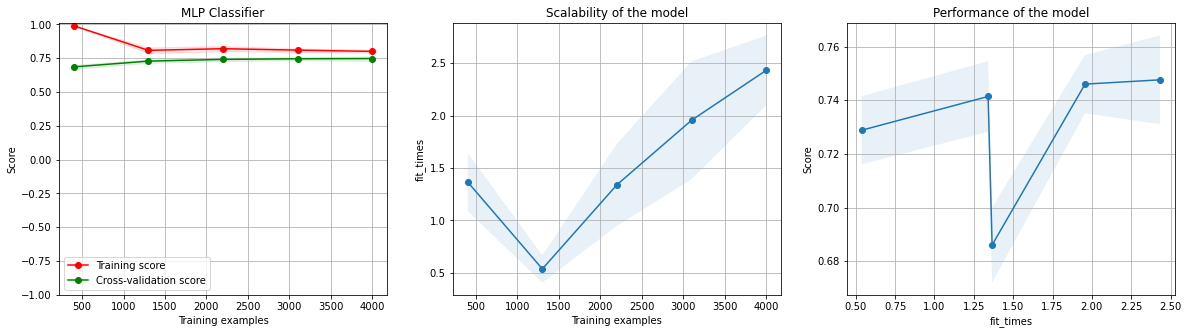

In [40]:
plot_learning_curve(
    clf, "MLP Classifier", X, y,ylim=(-1, 1.01), cv=5, n_jobs=4
)

# All base stats normally appended to the data types as one hot encoding


In [41]:
# limit to categorical data using df.select_dtypes()
data_one_hot_encoding = pd.DataFrame( data_one_hot_encoding,columns=['Type 1', 'Type 2', 'HP', 'Attack',
                                                   'Defense', 'Sp. Atk','Sp. Def', 'Speed',
                                                   'Generation', 'Legendary', 'Type 1', 'Type 2',
                                                   'HP', 'Attack',
                                                   'Defense', 'Sp. Atk','Sp. Def', 'Speed',
                                                   'Generation', 'Legendary', 'Winner'] )
save = data_one_hot_encoding.copy()

data_one_hot_encoding = data_one_hot_encoding.astype({'HP' : 'int32', 'Attack': 'int32',
                                                      'Defense': 'int32','Sp. Atk': 'int32',
                                                      'Sp. Def' : 'int32','Speed' : 'int32',
                                                      'Generation': 'int32', 'Legendary': 'int32', 'Winner': 'int32'})
print(data_one_hot_encoding.dtypes)
X_objects = data_one_hot_encoding.select_dtypes(include=[object])
X_objects.head(3)

Type 1        object
Type 2        object
HP             int32
Attack         int32
Defense        int32
Sp. Atk        int32
Sp. Def        int32
Speed          int32
Generation     int32
Legendary      int32
Type 1        object
Type 2        object
HP             int32
Attack         int32
Defense        int32
Sp. Atk        int32
Sp. Def        int32
Speed          int32
Generation     int32
Legendary      int32
Winner         int32
dtype: object


,Type 1,Type 2,Type 1,Type 2
0,Rock,Ground,Grass,Dark
1,Grass,Fighting,Rock,Fighting
2,Fairy,Flying,Psychic,NA


In [42]:

# 1. INSTANTIATE
# encode labels with value between 0 and n_classes-1.
le = preprocessing.LabelEncoder()

# 2/3. FIT AND TRANSFORM
# use df.apply() to apply le.fit_transform to all columns
X_objects_fitted = X_objects.apply(le.fit_transform)
X_objects_fitted.head()

# limit to categorical data using df.select_dtypes()
enc = preprocessing.OneHotEncoder()

# 2. FIT
enc.fit(X_objects_fitted)

# 3. Transform
onehotlabels = enc.transform(X_objects_fitted).toarray()
onehotlabels.shape
panda_Hot = pd.DataFrame(onehotlabels)
X_data_one_Hot = data_one_hot_encoding.drop(columns=["Winner", "Type 1", "Type 2"])

X_data_one_Hot = X_data_one_Hot.join(panda_Hot)
X_data_one_Hot.head()

,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,HP,Attack,...,64,65,66,67,68,69,70,71,72,73
0,50,64,50,45,50,41,2,0,70,70,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,91,90,72,90,129,108,5,1,91,129,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,55,40,85,80,105,40,2,0,75,75,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,40,40,40,70,40,20,2,0,77,120,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,70,60,125,115,70,55,1,0,20,10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [43]:
X_train, X_test, y_train, y_test = train_test_split(X_data_one_Hot, y, test_size=0.25, random_state=42)
print(X_train.shape)
print(y_train.shape)

(3750, 90)
(3750,)


In [44]:
#this is bad3!
clf = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(100, X_data_one_Hot.shape[1]), random_state=1, max_iter=100000000)

y = data_one_hot_encoding.Winner
print(y.shape)

model = clf.fit(X_train, y_train)
pred = model.predict(X_test)
print(set(pred))
print(set(y_test))
# print('Accuracy of {}:'.format(name), accuracy_score(pred, y_test))
print('Accuracy :', accuracy_score(pred, y_test))
print(classification_report(y_test, pred))

(5001,)
{0, 1}
{0, 1}
Accuracy : 0.9072741806554756
              precision    recall  f1-score   support

           0       0.92      0.88      0.90       574
           1       0.90      0.93      0.92       677

    accuracy                           0.91      1251
   macro avg       0.91      0.91      0.91      1251
weighted avg       0.91      0.91      0.91      1251



<module 'matplotlib.pyplot' from '/opt/anaconda/lib/python3.8/site-packages/matplotlib/pyplot.py'>

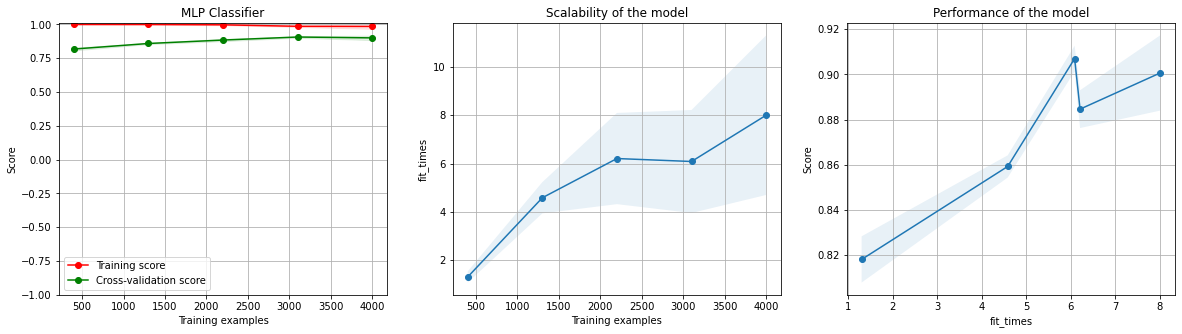

In [45]:
plot_learning_curve(
    clf, "MLP Classifier", X_data_one_Hot, y,ylim=(-1, 1.01), cv=5, n_jobs=4
)

Accuracy : 0.8816946442845723
              precision    recall  f1-score   support

           0       0.86      0.88      0.87       574
           1       0.90      0.88      0.89       677

    accuracy                           0.88      1251
   macro avg       0.88      0.88      0.88      1251
weighted avg       0.88      0.88      0.88      1251



<AxesSubplot:>

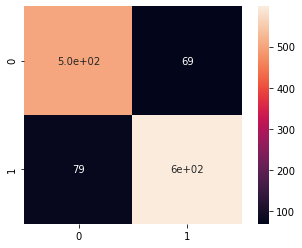

In [46]:
# Random Forest Classifier difference between most imp features
# Attack Diff Speed Dif
clf = RandomForestClassifier(n_estimators=100)
model = clf.fit(X_train,y_train)

pred = model.predict(X_test)
# print('Accuracy of {}:'.format(name), accuracy_score(pred, y_test))
print('Accuracy :', accuracy_score(pred, y_test))
print(classification_report(y_test, pred))
sns.heatmap(confusion_matrix(y_test, pred), square=True, annot=True)

<module 'matplotlib.pyplot' from '/opt/anaconda/lib/python3.8/site-packages/matplotlib/pyplot.py'>

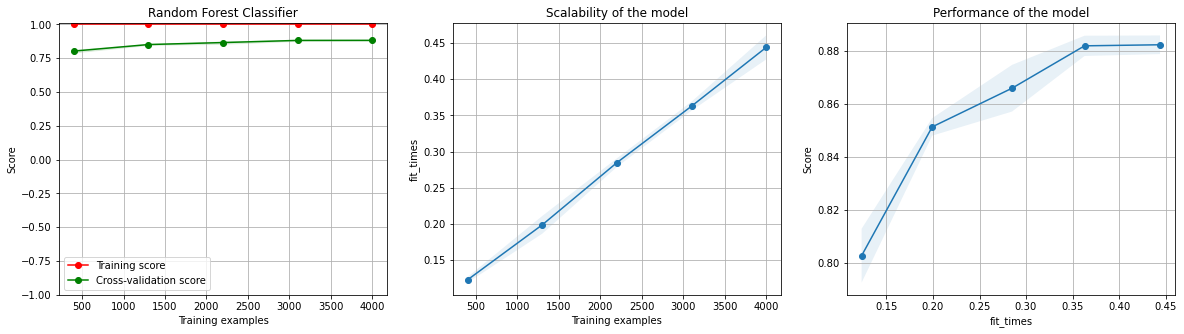

In [47]:
plot_learning_curve(
    clf, "Random Forest Classifier", X_data_one_Hot, y,ylim=(-1, 1.01), cv=5, n_jobs=4
)

88.33 percent


<AxesSubplot:>

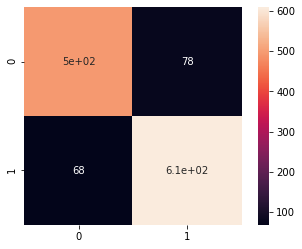

In [48]:
clf = LogisticRegression(C=0.1,max_iter=10000)
clf.fit(X_train, y_train)
y_pred_log_reg = clf.predict(X_test)
acc_log_reg = round( clf.score(X_test, y_test) * 100, 2)
print(str(acc_log_reg) + ' percent')
sns.heatmap(confusion_matrix(y_test,y_pred_log_reg ), square=True, annot=True)

<module 'matplotlib.pyplot' from '/opt/anaconda/lib/python3.8/site-packages/matplotlib/pyplot.py'>

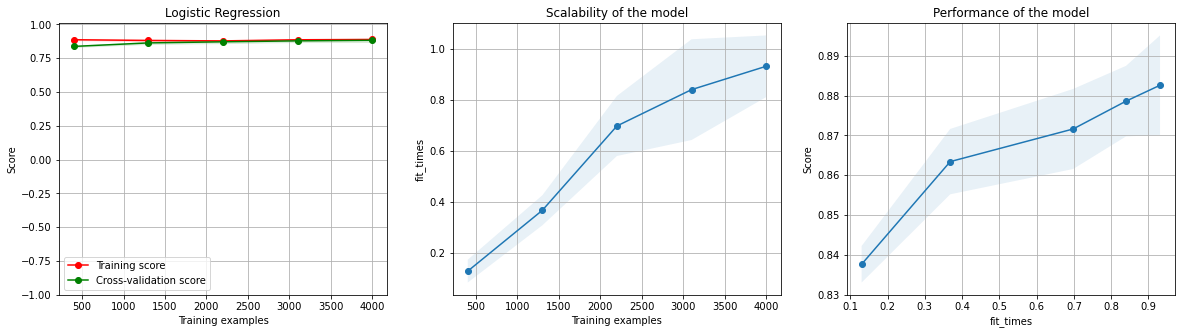

In [49]:
plot_learning_curve(
    clf, "Logistic Regression", X_data_one_Hot, y,ylim=(-1, 1.01), cv=5, n_jobs=4
)

# Third Approach

Use only attack speed and types as a map

In [50]:
X = data_with_types[["Type 1", "Type 2", "Attack", "Speed"]]
X.head(3)

,Type 1,Type 1,Type 2,Type 2,Attack,Attack,Speed,Speed
0,9,14,4,3,64,70,41,60
1,14,9,5,5,90,129,108,108
2,6,17,7,0,40,75,40,40


In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(X_train.shape)
print(y_train.shape)

(3750, 8)
(3750,)


In [52]:
#this is bad3!
clf = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(100, X.shape[1]), random_state=1, max_iter=100000000)

y = data_one_hot_encoding.Winner
print(y.shape)

model = clf.fit(X_train, y_train)
pred = model.predict(X_test)
print(set(pred))
print(set(y_test))
# print('Accuracy of {}:'.format(name), accuracy_score(pred, y_test))
print('Accuracy :', accuracy_score(pred, y_test))
print(classification_report(y_test, pred))

(5001,)
{0, 1}
{0, 1}
Accuracy : 0.926458832933653
              precision    recall  f1-score   support

           0       0.89      0.95      0.92       574
           1       0.96      0.90      0.93       677

    accuracy                           0.93      1251
   macro avg       0.93      0.93      0.93      1251
weighted avg       0.93      0.93      0.93      1251



<module 'matplotlib.pyplot' from '/opt/anaconda/lib/python3.8/site-packages/matplotlib/pyplot.py'>

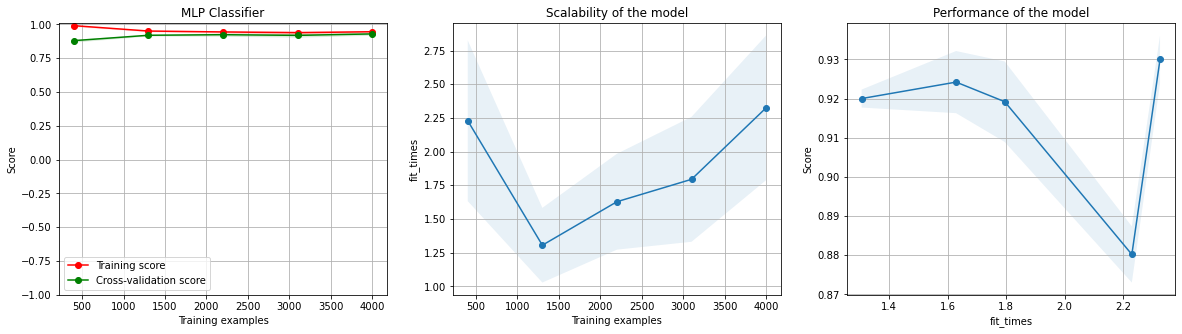

In [53]:
plot_learning_curve(
    clf, "MLP Classifier", X, y,ylim=(-1, 1.01), cv=5, n_jobs=4
)

Accuracy : 0.9232613908872902
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       574
           1       0.93      0.93      0.93       677

    accuracy                           0.92      1251
   macro avg       0.92      0.92      0.92      1251
weighted avg       0.92      0.92      0.92      1251



<AxesSubplot:>

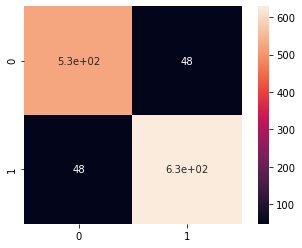

In [54]:
# Random Forest Classifier difference between most imp features
# Attack Diff Speed Dif
clf = RandomForestClassifier(n_estimators=100)
model = clf.fit(X_train,y_train)

pred = model.predict(X_test)
# print('Accuracy of {}:'.format(name), accuracy_score(pred, y_test))
print('Accuracy :', accuracy_score(pred, y_test))
print(classification_report(y_test, pred))
sns.heatmap(confusion_matrix(y_test, pred), square=True, annot=True)

<module 'matplotlib.pyplot' from '/opt/anaconda/lib/python3.8/site-packages/matplotlib/pyplot.py'>

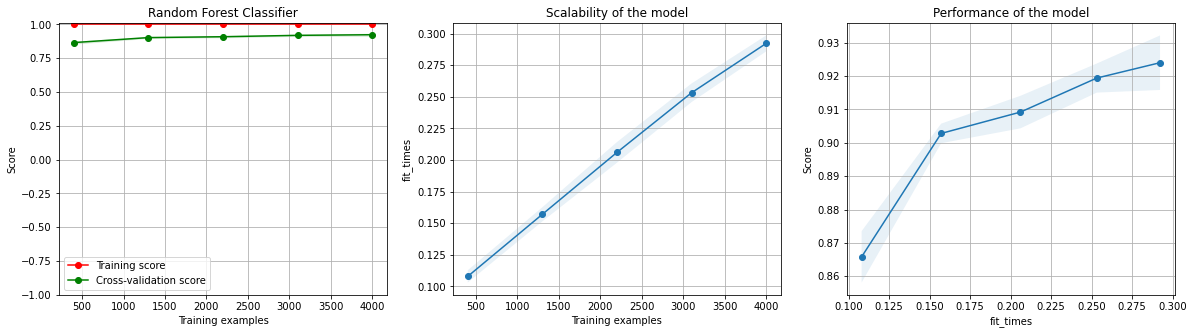

In [55]:
plot_learning_curve(
    clf, "Random Forest Classifier", X, y,ylim=(-1, 1.01), cv=5, n_jobs=4
)

88.65 percent


<AxesSubplot:>

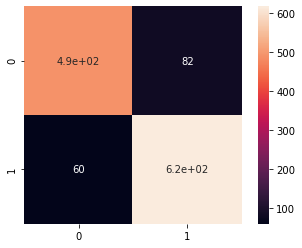

In [56]:

clf = LogisticRegression(C=0.1,max_iter=10000)
clf.fit(X_train, y_train)
y_pred_log_reg = clf.predict(X_test)
acc_log_reg = round( clf.score(X_test, y_test) * 100, 2)
print(str(acc_log_reg) + ' percent')
sns.heatmap(confusion_matrix(y_test,y_pred_log_reg  ), square=True, annot=True)

<module 'matplotlib.pyplot' from '/opt/anaconda/lib/python3.8/site-packages/matplotlib/pyplot.py'>

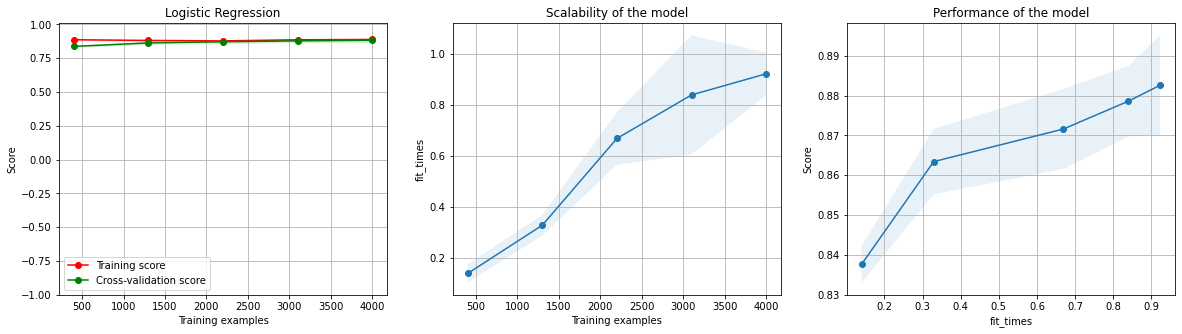

In [57]:
plot_learning_curve(
    clf, "Logistic Regression", X_data_one_Hot, y,ylim=(-1, 1.01), cv=5, n_jobs=4
)

# Use difference stats and types mapped to integers

In [58]:
X_Most_Imp_Features = X_Most_Imp_Features.join(data_with_types[["Type 1", "Type 2"]])


In [59]:
X_Most_Imp_Features.head(3)

,Attack Diff,Speed diff,Type 1,Type 1,Type 2,Type 2
0,-6,-19,9,14,4,3
1,-39,0,14,9,5,5
2,-35,0,6,17,7,0


In [60]:
X_train, X_test, y_train, y_test = train_test_split(X_Most_Imp_Features, y, test_size=0.25, random_state=42)
randomFlorestclf = RandomForestClassifier(n_estimators=100)
model = randomFlorestclf.fit(X_train,y_train)
pred = model.predict(X_test)
# print('Accuracy of {}:'.format(name), accuracy_score(pred, y_test))
print('Accuracy :', accuracy_score(pred, y_test))
print(classification_report(y_test, pred))

Accuracy : 0.9544364508393285
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       574
           1       0.96      0.96      0.96       677

    accuracy                           0.95      1251
   macro avg       0.95      0.95      0.95      1251
weighted avg       0.95      0.95      0.95      1251



<module 'matplotlib.pyplot' from '/opt/anaconda/lib/python3.8/site-packages/matplotlib/pyplot.py'>

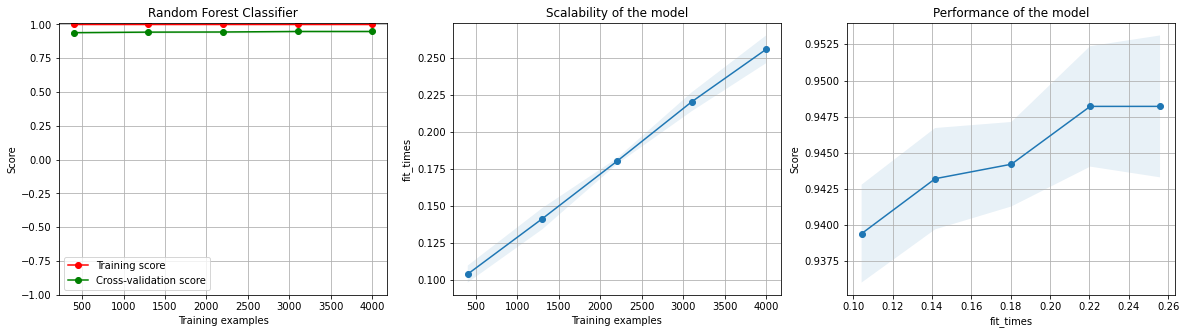

In [61]:
plot_learning_curve(
    randomFlorestclf, "Random Forest Classifier", X_Most_Imp_Features, y,ylim=(-1, 1.01), cv=5, n_jobs=4
)